<a href="https://colab.research.google.com/github/JusiaJusia/Traffic-Sign-Recognition/blob/master/Tuning_hyperparameter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install hyperopt

In [0]:
import pandas as pd
import numpy as np
import os
import datetime 

import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

%load_ext tensorboard

import matplotlib.pyplot as plt
from skimage import color, exposure

from sklearn.metrics import accuracy_score

from hyperopt import hp, STATUS_OK, tpe, Trials, fmin

In [3]:
cd '/content/drive/My Drive/Colab Notebooks/matrix/m_3/data'

/content/drive/My Drive/Colab Notebooks/matrix/m_3/data


In [0]:
train = pd.read_pickle('train.p')
test = pd.read_pickle('test.p')

X_train, y_train = train['features'],train['labels']
X_test, y_test = test['features'],test['labels']


In [0]:
if y_train.ndim == 1: y_train = to_categorical(y_train)
if y_test.ndim == 1: y_test = to_categorical(y_test)

In [0]:
input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]

In [0]:
def train_model(model, X_train,y_train, params_fit={}): 
  model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

  logdir = os.path.join('logs', datetime.datetime.now().strftime('"%m/%d/%Y-%H:%M:%S"'))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
  
  model.fit(
      X_train, 
      y_train,
      batch_size = params_fit.get('batch_size', 128),
      epochs = params_fit.get('epochs', 5),
      verbose = params_fit.get('verbose', 1),
      validation_data = params_fit.get('validation_data', (X_train,y_train)),
      callbacks = [tensorboard_callback]
      )
  return model

In [0]:
def predict(model_trained, X_test, y_test, scoring = accuracy_score ):

  y_test_norm = np.argmax(y_test, axis=1)

  y_pred_probability=model_trained.predict(X_test)
  y_pred = np.argmax(y_pred_probability, axis=1)

  return scoring(y_test_norm, y_pred)

In [0]:
def get_cnn_v5(input_shape,num_classes):
  return Sequential([
    Conv2D(filters=32,kernel_size=(3,3),activation='relu', input_shape = input_shape),
    Conv2D(filters=32,kernel_size=(3,3),activation='relu', padding = 'same'),

    MaxPool2D(),
    Dropout(0.3),


    Conv2D(filters=64,kernel_size=(3,3),activation='relu', padding = 'same'),
    Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64,kernel_size=(3,3),activation='relu', padding = 'same'),
    Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Flatten(),

    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax'),
])



In [10]:
model=get_cnn_v5(input_shape, num_classes)
model_trained = train_model(model, X_train, y_train)

predict(model_trained, X_test, y_test)

Epoch 1/5
272/272 [==============================] - 6s 24ms/step - loss: 2.3573 - accuracy: 0.3285 - val_loss: 0.9903 - val_accuracy: 0.7050
Epoch 2/5
272/272 [==============================] - 6s 22ms/step - loss: 0.7736 - accuracy: 0.7501 - val_loss: 0.1636 - val_accuracy: 0.9495
Epoch 3/5
272/272 [==============================] - 6s 22ms/step - loss: 0.3435 - accuracy: 0.8960 - val_loss: 0.0829 - val_accuracy: 0.9773
Epoch 4/5
272/272 [==============================] - 6s 23ms/step - loss: 0.2119 - accuracy: 0.9378 - val_loss: 0.0470 - val_accuracy: 0.9856
Epoch 5/5
272/272 [==============================] - 6s 22ms/step - loss: 0.1647 - accuracy: 0.9514 - val_loss: 0.0269 - val_accuracy: 0.9923


0.9757369614512472

In [0]:
def get_model(params):
  return Sequential([
    Conv2D(filters=32,kernel_size=(3,3),activation='relu', input_shape = input_shape),
    Conv2D(filters=32,kernel_size=(3,3),activation='relu', padding = 'same'),
    MaxPool2D(),
    Dropout(params['dropout_cnn_block_one']),


    Conv2D(filters=64,kernel_size=(3,3),activation='relu', padding = 'same'),
    Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
    MaxPool2D(),
    Dropout(params['dropout_cnn_block_two']),

    Conv2D(filters=128,kernel_size=(3,3),activation='relu', padding = 'same'),
    Conv2D(filters=128,kernel_size=(3,3),activation='relu'),
    MaxPool2D(),
    Dropout(params['dropout_cnn_block_three']),

    Flatten(),

    Dense(1024, activation='relu'),
    Dropout(params['dropout_dense_block_one']),

    Dense(1024, activation='relu'),
    Dropout(params['dropout_dense_block_two']),

    Dense(num_classes, activation='softmax'),
])


In [0]:
def func_obj(params): 
  model=get_model(params)
  model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

  model.fit(
      X_train, 
      y_train,
      batch_size =128, #int(params.get('batch_size', 128)),
      epochs = 5,
      verbose = 0
      )
  
  score = model.evaluate(X_test, y_test, verbose = 0)
  accuracy = score[1]
  print(params, 'accuracy={}'.format(accuracy))

  return {'loss': -accuracy, 'status': STATUS_OK, 'model': model }

In [28]:
space = {
    'batch_size': hp.quniform('batch_size', 50, 200, 20),
    'dropout_cnn_block_one': hp.uniform('dropout_cnn_block_one', 0.3, 0.5),
    'dropout_cnn_block_two': hp.uniform('dropout_cnn_block_two', 0.3, 0.5),
    'dropout_cnn_block_three': hp.uniform('dropout_cnn_block_three', 0.3, 0.5),

    'dropout_dense_block_one': hp.uniform('dropout_dense_block_one', 0.3, 0.7),
    'dropout_dense_block_two': hp.uniform('dropout_dense_block_two', 0.3, 0.7),
  }

best = fmin(
    func_obj,
    space,
    tpe.suggest,
    30,
    Trials()
)


{'batch_size': 80.0, 'dropout_cnn_block_one': 0.4918977185076108, 'dropout_cnn_block_three': 0.3356431201131449, 'dropout_cnn_block_two': 0.41182206938973226, 'dropout_dense_block_one': 0.4187675484711448, 'dropout_dense_block_two': 0.42296561526937915}
accuracy=0.9362812042236328
{'batch_size': 60.0, 'dropout_cnn_block_one': 0.47162145675603145, 'dropout_cnn_block_three': 0.3615023499308931, 'dropout_cnn_block_two': 0.32157732836291636, 'dropout_dense_block_one': 0.3094761162202702, 'dropout_dense_block_two': 0.6032902168233961}
accuracy=0.9337868690490723
{'batch_size': 140.0, 'dropout_cnn_block_one': 0.41040230097419794, 'dropout_cnn_block_three': 0.3214323768702455, 'dropout_cnn_block_two': 0.3416285210906584, 'dropout_dense_block_one': 0.699030546524297, 'dropout_dense_block_two': 0.5194608344838847}
accuracy=0.8408163189888
{'batch_size': 80.0, 'dropout_cnn_block_one': 0.323552565805668, 'dropout_cnn_block_three': 0.322406114289355, 'dropout_cnn_block_two': 0.43784514219823145, '

In [0]:
#%tensorboard --logdir logs

In [0]:
from tensorflow.keras.layers import Conv1D

In [0]:
X_train_grey = color.rgb2gray(X_train).reshape(-1,32,32,1)
X_test_gray = color.rgb2gray(X_test).reshape(-1,32,32,1)

In [0]:
model = get_cnn_v5((32,32,1), num_classes)
model_trained = train_model(model, X_train_grey, y_train, params_fit={})
predict(model_trained, X_test_gray, y_test)

Epoch 1/5
272/272 [==============================] - 13s 46ms/step - loss: 2.8675 - accuracy: 0.2085 - val_loss: 0.8100 - val_accuracy: 0.7523
Epoch 2/5
272/272 [==============================] - 12s 45ms/step - loss: 0.6115 - accuracy: 0.7982 - val_loss: 0.1284 - val_accuracy: 0.9638
Epoch 3/5
272/272 [==============================] - 12s 45ms/step - loss: 0.2431 - accuracy: 0.9220 - val_loss: 0.0548 - val_accuracy: 0.9845
Epoch 4/5
272/272 [==============================] - 12s 45ms/step - loss: 0.1485 - accuracy: 0.9534 - val_loss: 0.0343 - val_accuracy: 0.9905
Epoch 5/5
272/272 [==============================] - 12s 45ms/step - loss: 0.1093 - accuracy: 0.9656 - val_loss: 0.0183 - val_accuracy: 0.9953


0.9682539682539683

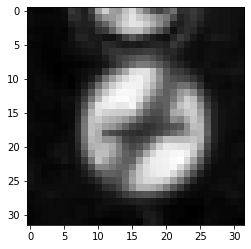

In [0]:
plt.imshow(color.rgb2gray(X_train[0]), cmap = plt.get_cmap('gray'))